In [3]:
# %load script.py
#! /usr/bin/env python2


# import module
import os
adress_abs = os.getcwd()
import sys
sys.path.append(adress_abs+"/scripts") # Contains "util" and "Polygenic_score" packages
import util
from Polygenic_score_BP import *

import subprocess
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import re

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Fonctions

In [4]:
def write_cov_file(pca_file,nb_pc):

    cmd_sed = "sed -i -e \"s/:/ /g\" -e \"s/\s\+/\t/g\" -e \"s/^\s\+//g\" {}".format(pca_file)
    p = subprocess.Popen(cmd_sed, shell=True)
    assert(p.wait()==0)
    
    cov_file = pca_file[:-9]+".cov"
    a=""
    for i in range(nb_pc):
        a=a+("\tPC{}".format(i+1))
    

    cmd_print = "printf \"FID\tIID{}\n\" > {}".format(a,cov_file)

    p = subprocess.Popen(cmd_print, shell=True)
    assert(p.wait()==0)

    cmd_tail = "tail -n+2 {} | cut -f1-{} >> {}".format(pca_file, 2+nb_pc, cov_file) 

    #-n+2 récup lignes en commançant par le 2ème
    #-f1-2+nb_pc résup les champs 1-nb_pc+2
    
    p = subprocess.Popen(cmd_tail, shell=True)
    assert(p.wait()==0)
    
    print "Wrote {}".format(cov_file)

In [5]:
def save_strat(strat_file, strat):
    pca_res = pd.read_table(strat_file, delim_whitespace=True, skiprows=1, header=None)
    PCs_out = strat + ".PCs"
    with open(PCs_out, "a") as f:
        f.write(', '.join(pca_res[0].values))
        f.write('\n')
        f.write(str(pca_res[2].values.tolist())[1:-1])
        f.write('\n')
        f.write(str(pca_res[3].values.tolist())[1:-1])
        f.write('\n')

In [6]:
def plink_prune(plink_bfile):

    cmd_prune = """plink --bfile {}      --exclude /home/vcabeli/Documents/data/high-LD-regions_37.txt           --range --indep-pairwise 50 5 0.2           --allow-extra-chr           --out {}""".format(plink_bfile, plink_bfile+"_prune")
    p = subprocess.Popen(cmd_prune, shell=True)
    assert(p.wait() == 0)

    cmd_extract = """plink --bfile {}           --extract {}           --allow-extra-chr           --chr 1-23           --make-bed           --out {}""".format(plink_bfile, plink_bfile + "_prune.prune.in", 
                             plink_bfile + "_pruned")
    p = subprocess.Popen(cmd_extract, shell=True)
    assert(p.wait() == 0)

    print "Wrote {} bed/bim/fam.".format(plink_bfile + "_pruned")

In [7]:
def cov_file(file_name,training_sample_out,thresh_LD,k=2):   

    #creer le fichier de covariables 
    cmd_keep_plink = "plink --bfile {} --keep {} --make-bed --out {}".format("/home/vcabeli/Documents/data/BP_final/BP.B37-final",
                                                                         training_sample_out,
                                                                         "training_set")
    print cmd_keep_plink
    p = subprocess.Popen(cmd_keep_plink, shell=True)
    p.wait()
    cmd_extract_low_ld_snps = "plink --bfile {} --extract {} --make-bed --out {}".format("training_set",
                                                                                     "L2_thresh_{}_BP.extract".format(thresh_LD),
                                                                                     file_name)
    print cmd_extract_low_ld_snps
    p = subprocess.Popen(cmd_extract_low_ld_snps, shell=True)
    assert(p.wait()==0)

    plink_prune(file_name)
    #########################################PCA 1 ###########################
    #k = nombrede PC
    cmd_smart_pca2 = "smartpca.perl -i {} -a {} -b {} -o {} -p {} -e {} -l {} -k {} -t {} -m {}".format("{}_pruned.bed".format(file_name),
                                                                                                  "{}_pruned.bim".format(file_name),
                                                                                                   "{}_pruned.fam".format(file_name),
                                                                                                   "{}_pruned.pca".format(file_name),
                                                                                                   "{}_pruned.plot".format(file_name),
                                                                                                   "{}_pruned.eval".format(file_name),
                                                                                                   "{}_pruned.log".format(file_name),
                                                                                                   k, 2, 0)
    print cmd_smart_pca2
    p = subprocess.Popen(cmd_smart_pca2, shell=True)
    p.wait()
    #écriture fichier covariables
    write_cov_file("{}_pruned.pca.evec".format(file_name),k)
    save_strat("{}_pruned.pca.evec".format(file_name), "low_ld{}".format(thresh_LD)) #OUTPUT LINE
    return("{}_pruned".format(file_name))

In [8]:
def test(file_pca,n_iter,nb_pc):
    threshs = range(10, 250140, 500)
    threshs_clumped = range(10, 80000,300)
    thresh_LD = 5 

    snp_data, pheno = util.load_data("/home/vcabeli/Documents/data/BP_final/BP.B37-final")
    pheno['bp_type'] = np.zeros(snp_data.row_count)
    
    logistic_res = pd.read_table("/home/vcabeli/Documents/analyses_current/assoc/genotyped/class_logistic..assoc.logistic",
                             delim_whitespace=True)
    logistic_res = logistic_res[logistic_res.TEST == "ADD"]
    logistic_res.reset_index(drop=True, inplace=True)

    res_hw_pval_sign = np.zeros([n_iter, len(threshs)])

    for iteration in range(n_iter):

        print "=========================Iteration {}=========================".format(iteration)

        train_idces = np.random.choice(np.arange(snp_data.row_count), size=int(snp_data.row_count*0.5), replace=False)
        test_idces = np.setdiff1d(np.arange(snp_data.row_count), train_idces, assume_unique=True)

        stats_sets = pd.DataFrame(index= ['Training', 'Test'],
                                  columns=['n_controls', 'n_cases', 'n_bp1', 'n_bp2'])

        for i, idces in enumerate([train_idces, test_idces]):
            stats_sets.iloc[i]['n_controls'] = np.count_nonzero([pheno['vals'][j] == 1 for j in idces])
            stats_sets.iloc[i]['n_cases'] = np.count_nonzero([pheno['vals'][j] == 2 for j in idces])
            stats_sets.iloc[i]['n_bp1'] = np.count_nonzero(pheno['bp_type'][idces] == 1)
            stats_sets.iloc[i]['n_bp2'] = np.count_nonzero(pheno['bp_type'][idces] == 2)




        training_sample_out = "training_samples.keep"

        with open(training_sample_out, 'w') as f:
            for i in train_idces:
                f.write(pheno['iid'][i][0] + "\t" + pheno['iid'][i][1])
                f.write("\n")

        file_cov = cov_file(file_pca, training_sample_out,thresh_LD, nb_pc)
                
        G_hw = snp_data.val.copy()

        MAFs = np.nansum(2-G_hw, axis=0, ) / (np.count_nonzero(~np.isnan(G_hw), axis=0) * 2)
        # ## Classical polygenic score : pvalue threshold, logistic $\beta$s
        #
        # Where SNP selection is based on their logitic association test p-value and weights are the $\beta$s.




        cmd_plink = "plink --bfile {} --keep {} --logistic sex beta --covar {} --hide-covar --out {}".format("/home/vcabeli/Documents/data/BP_final/BP.B37-final",
                                                                                                             training_sample_out,
                                                                                                             "{}.cov".format(file_cov),
                                                                                                             "train_log")

        print cmd_plink
        p = subprocess.Popen(cmd_plink, shell=True)
        p.wait()

        train_res = pd.read_table("train_log.assoc.logistic", delim_whitespace=True)
        assert(np.all(logistic_res.SNP == train_res.SNP))



        util.control_idces = [i for i in train_idces if pheno['vals'][i] == 1]
        util.case_idces = [i for i in train_idces if pheno['vals'][i] == 2]






        sorted_snps_pval = np.argsort(train_res.P.values)




        # ## Coded genotyped
        #
        # Under Hardy-Weinberg equilibrium, $G_i = \frac{(X_i - 2 f_i)}{\sqrt{2fi(1-fi)}}$ where $X_i$ is the number of minor alleles and $f_i$ the minor allele frequency.


        ttest_test = polygen_score_sign(G_hw, sorted_snps_pval,
                                        threshs,
                                        test_idces, pheno,
                                        train_res.BETA)




        res_hw_pval_sign[iteration] = ttest_test





    return(res_hw_pval_sign)


## Main

In [9]:
n_iter = 10

print "==============================================PC==========================================================="
res_pval_3=test("PCA3",n_iter,3)

print "==============================================PC==========================================================="
res_pval_5=test("PCA5",n_iter,5)

==============================================PC===========================================================
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
=========================Iteration 0=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA3
Wrote PCA3_pruned bed/bim/fam.
smartpca.perl -i PCA3_pruned.bed -a PCA3_pruned.bim -b PCA3_pruned.fam -o PCA3_pruned.pca -p PCA3_pruned.plot -e PCA3_pruned.eval -l PCA3_pruned.log -k 3 -t 2 -m 0
Wrote PCA3_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA3_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:26<00:00, 19.23it/s]


=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA3
Wrote PCA3_pruned bed/bim/fam.
smartpca.perl -i PCA3_pruned.bed -a PCA3_pruned.bim -b PCA3_pruned.fam -o PCA3_pruned.pca -p PCA3_pruned.plot -e PCA3_pruned.eval -l PCA3_pruned.log -k 3 -t 2 -m 0
Wrote PCA3_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA3_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:26<00:00, 19.19it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA3
Wrote PCA3_pruned bed/bim/fam.
smartpca.perl -i PCA3_pruned.bed -a PCA3_pruned.bim -b PCA3_pruned.fam -o PCA3_pruned.pca -p PCA3_pruned.plot -e PCA3_pruned.eval -l PCA3_pruned.log -k 3 -t 2 -m 0
Wrote PCA3_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA3_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:26<00:00, 19.09it/s]


=========================Iteration 3=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA3
Wrote PCA3_pruned bed/bim/fam.
smartpca.perl -i PCA3_pruned.bed -a PCA3_pruned.bim -b PCA3_pruned.fam -o PCA3_pruned.pca -p PCA3_pruned.plot -e PCA3_pruned.eval -l PCA3_pruned.log -k 3 -t 2 -m 0
Wrote PCA3_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA3_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:26<00:00, 19.20it/s]


=========================Iteration 4=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA3
Wrote PCA3_pruned bed/bim/fam.
smartpca.perl -i PCA3_pruned.bed -a PCA3_pruned.bim -b PCA3_pruned.fam -o PCA3_pruned.pca -p PCA3_pruned.plot -e PCA3_pruned.eval -l PCA3_pruned.log -k 3 -t 2 -m 0
Wrote PCA3_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA3_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:26<00:00, 19.14it/s]


=========================Iteration 5=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA3
Wrote PCA3_pruned bed/bim/fam.
smartpca.perl -i PCA3_pruned.bed -a PCA3_pruned.bim -b PCA3_pruned.fam -o PCA3_pruned.pca -p PCA3_pruned.plot -e PCA3_pruned.eval -l PCA3_pruned.log -k 3 -t 2 -m 0
Wrote PCA3_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA3_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:27<00:00, 18.39it/s]


=========================Iteration 6=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA3
Wrote PCA3_pruned bed/bim/fam.
smartpca.perl -i PCA3_pruned.bed -a PCA3_pruned.bim -b PCA3_pruned.fam -o PCA3_pruned.pca -p PCA3_pruned.plot -e PCA3_pruned.eval -l PCA3_pruned.log -k 3 -t 2 -m 0
Wrote PCA3_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA3_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:28<00:00, 17.33it/s]


=========================Iteration 7=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA3
Wrote PCA3_pruned bed/bim/fam.
smartpca.perl -i PCA3_pruned.bed -a PCA3_pruned.bim -b PCA3_pruned.fam -o PCA3_pruned.pca -p PCA3_pruned.plot -e PCA3_pruned.eval -l PCA3_pruned.log -k 3 -t 2 -m 0
Wrote PCA3_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA3_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:29<00:00, 16.97it/s]


=========================Iteration 8=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA3
Wrote PCA3_pruned bed/bim/fam.
smartpca.perl -i PCA3_pruned.bed -a PCA3_pruned.bim -b PCA3_pruned.fam -o PCA3_pruned.pca -p PCA3_pruned.plot -e PCA3_pruned.eval -l PCA3_pruned.log -k 3 -t 2 -m 0
Wrote PCA3_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA3_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:26<00:00, 18.83it/s]


=========================Iteration 9=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA3
Wrote PCA3_pruned bed/bim/fam.
smartpca.perl -i PCA3_pruned.bed -a PCA3_pruned.bim -b PCA3_pruned.fam -o PCA3_pruned.pca -p PCA3_pruned.plot -e PCA3_pruned.eval -l PCA3_pruned.log -k 3 -t 2 -m 0
Wrote PCA3_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA3_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:28<00:00, 17.53it/s]


==============================================PC===========================================================
Using last column in .fam file as phenotype.
	Considering phenotype as a plink binary 1/2.
	Found 427 cases and 1525 controls.
Loaded 1952 samples and 250140 SNPs.
=========================Iteration 0=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA5
Wrote PCA5_pruned bed/bim/fam.
smartpca.perl -i PCA5_pruned.bed -a PCA5_pruned.bim -b PCA5_pruned.fam -o PCA5_pruned.pca -p PCA5_pruned.plot -e PCA5_pruned.eval -l PCA5_pruned.log -k 5 -t 2 -m 0
Wrote PCA5_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA5_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:27<00:00, 18.20it/s]


=========================Iteration 1=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA5
Wrote PCA5_pruned bed/bim/fam.
smartpca.perl -i PCA5_pruned.bed -a PCA5_pruned.bim -b PCA5_pruned.fam -o PCA5_pruned.pca -p PCA5_pruned.plot -e PCA5_pruned.eval -l PCA5_pruned.log -k 5 -t 2 -m 0
Wrote PCA5_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA5_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:26<00:00, 18.57it/s]


=========================Iteration 2=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA5
Wrote PCA5_pruned bed/bim/fam.
smartpca.perl -i PCA5_pruned.bed -a PCA5_pruned.bim -b PCA5_pruned.fam -o PCA5_pruned.pca -p PCA5_pruned.plot -e PCA5_pruned.eval -l PCA5_pruned.log -k 5 -t 2 -m 0
Wrote PCA5_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA5_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:26<00:00, 19.06it/s]


=========================Iteration 3=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA5
Wrote PCA5_pruned bed/bim/fam.
smartpca.perl -i PCA5_pruned.bed -a PCA5_pruned.bim -b PCA5_pruned.fam -o PCA5_pruned.pca -p PCA5_pruned.plot -e PCA5_pruned.eval -l PCA5_pruned.log -k 5 -t 2 -m 0
Wrote PCA5_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA5_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:31<00:00, 16.03it/s]


=========================Iteration 4=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA5
Wrote PCA5_pruned bed/bim/fam.
smartpca.perl -i PCA5_pruned.bed -a PCA5_pruned.bim -b PCA5_pruned.fam -o PCA5_pruned.pca -p PCA5_pruned.plot -e PCA5_pruned.eval -l PCA5_pruned.log -k 5 -t 2 -m 0
Wrote PCA5_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA5_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:30<00:00, 16.54it/s]


=========================Iteration 5=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA5
Wrote PCA5_pruned bed/bim/fam.
smartpca.perl -i PCA5_pruned.bed -a PCA5_pruned.bim -b PCA5_pruned.fam -o PCA5_pruned.pca -p PCA5_pruned.plot -e PCA5_pruned.eval -l PCA5_pruned.log -k 5 -t 2 -m 0
Wrote PCA5_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA5_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:28<00:00, 17.45it/s]


=========================Iteration 6=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA5
Wrote PCA5_pruned bed/bim/fam.
smartpca.perl -i PCA5_pruned.bed -a PCA5_pruned.bim -b PCA5_pruned.fam -o PCA5_pruned.pca -p PCA5_pruned.plot -e PCA5_pruned.eval -l PCA5_pruned.log -k 5 -t 2 -m 0
Wrote PCA5_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA5_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:26<00:00, 18.77it/s]


=========================Iteration 7=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA5
Wrote PCA5_pruned bed/bim/fam.
smartpca.perl -i PCA5_pruned.bed -a PCA5_pruned.bim -b PCA5_pruned.fam -o PCA5_pruned.pca -p PCA5_pruned.plot -e PCA5_pruned.eval -l PCA5_pruned.log -k 5 -t 2 -m 0
Wrote PCA5_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA5_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:26<00:00, 18.72it/s]


=========================Iteration 8=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA5
Wrote PCA5_pruned bed/bim/fam.
smartpca.perl -i PCA5_pruned.bed -a PCA5_pruned.bim -b PCA5_pruned.fam -o PCA5_pruned.pca -p PCA5_pruned.plot -e PCA5_pruned.eval -l PCA5_pruned.log -k 5 -t 2 -m 0
Wrote PCA5_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA5_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:29<00:00, 17.14it/s]


=========================Iteration 9=========================
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --make-bed --out training_set
plink --bfile training_set --extract L2_thresh_5_BP.extract --make-bed --out PCA5
Wrote PCA5_pruned bed/bim/fam.
smartpca.perl -i PCA5_pruned.bed -a PCA5_pruned.bim -b PCA5_pruned.fam -o PCA5_pruned.pca -p PCA5_pruned.plot -e PCA5_pruned.eval -l PCA5_pruned.log -k 5 -t 2 -m 0
Wrote PCA5_pruned.cov
plink --bfile /home/vcabeli/Documents/data/BP_final/BP.B37-final --keep training_samples.keep --logistic sex beta --covar PCA5_pruned.cov --hide-covar --out train_log


100%|██████████| 501/501 [00:26<00:00, 18.86it/s]


[[ 0.48158581  0.45893141  0.45292619 ...,  0.46393575  0.46395973
   0.46395373]
 [ 0.49233652  0.5033671   0.51208066 ...,  0.46655515  0.46656754
   0.46657374]
 [ 0.46738206  0.47834217  0.48021208 ...,  0.46338889  0.46338286
   0.46337682]
 ..., 
 [ 0.48132538  0.51233992  0.50049111 ...,  0.46789133  0.46788512
   0.46789133]
 [ 0.51293039  0.49278715  0.48120823 ...,  0.44713074  0.44713074
   0.44711876]
 [ 0.51174184  0.50704217  0.52323154 ...,  0.43151328  0.43149568
   0.43150155]]
Wrote test.pdf.


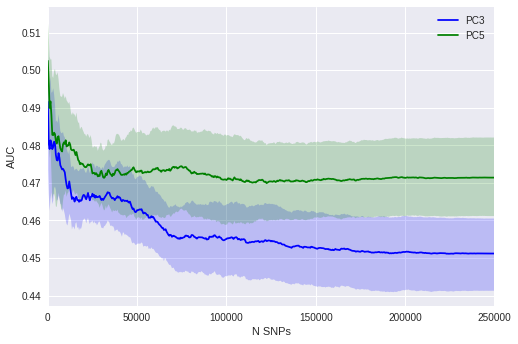

In [14]:
res_pval = res_pval_3
res_pval_2 = res_pval_5
print(res_pval)
time = range(10, 250140, 500)
for i in range(len(time)):
    res_pval[res_pval[:,i] == 0,i] = np.nan
    res_pval[np.isnan(res_pval[:,i]),i] = np.nanmedian(res_pval[:,i])
    
    res_pval_2[res_pval_2[:,i] == 0,i] = np.nan
    res_pval_2[np.isnan(res_pval_2[:,i]),i] = np.nanmedian(res_pval_2[:,i])


sns.tsplot(np.power(res_pval,1),color='b',ci=[0,95],time=time, condition="PC3")
sns.tsplot(np.power(res_pval_2,1),color='g',ci=[0,95],time=time, condition="PC5")
sns.plt.ylabel('AUC')
sns.plt.xlabel('N SNPs')
sns.plt.savefig("test.pdf", format="pdf")

print "Wrote {}.".format("test.pdf")

plt.show()